# DCGAN

## Deep Convolutional Generative Adversarial Networks

Using DCGAN to generate food images by learning from the Kaggle Food-101 datasets



---
### References

1. Original paper\
Radford et al. (2015) **Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks** [[arXiv](https://arxiv.org/abs/1511.06434)]

2. Tutorial on immplementation using MXNet [[link](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html)]

3. Lazy Programmer's GAN (with fully connected layers) Colab Notebook: https://colab.research.google.com/drive/1NGi0HyEuR8cMWyzmGzBiv06PDqmxZddY


# Check Google Colab GPU

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Oct  8 23:13:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    39W / 300W |   5215MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [12]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print("tensorflow version: {}".format(tf.__version__))

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, ReLU, LeakyReLU, Reshape, Flatten, UpSampling2D, AveragePooling2D
    
from tensorflow.keras.initializers import RandomNormal, RandomUniform
    
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

tensorflow version: 2.3.0


# Load the dataset

Before running the next cell, upload your dataset (for example, `food_c101_n10099_r64x64x3.h5`) to the current directory

In [13]:
import h5py

# dataset filename
filename = "food_c101_n10099_r64x64x3.h5"

food_dataset = h5py.File(filename, 'r')

print(food_dataset.keys())

category = np.array(food_dataset['category'])
category_names = np.array(food_dataset['category_names'])
orig_data = np.array(food_dataset['images'])

# check shape
orig_data.shape

<KeysViewHDF5 ['category', 'category_names', 'images']>


(10099, 64, 64, 3)

# Normalize pixels

We normalize the pixel values from [0, 255] to [-1, 1]

In [14]:
m = orig_data.shape[0]
h = orig_data.shape[1]
w = orig_data.shape[2]

# normalize pixel values from [0, 255] to [-1, 1]
data = (orig_data / 127.5) - 1
print("image normalized")
print("pixal min value = {}".format(data.min()))
print("pixal max value = {}".format(data.max()))


#data_flatten = np.copy(data).reshape(m, -1)
#print("data flatten: {}".format(data_flatten.shape))
# normalize pixel values from [0, 255] to [-1, 1]
#data_flatten = (data_flatten / 127.5) - 1
#print("pixal min value = {}".format(data_flatten.min()))
#print("pixal max value = {}".format(data_flatten.max()))

image normalized
pixal min value = -1.0
pixal max value = 1.0


# Display an example figure

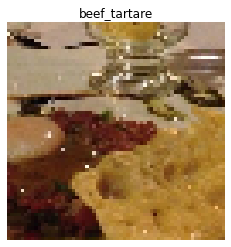

In [15]:
idx = 737

item_name = category_names[category[idx]][0].decode('utf-8')

plt.figure()
plt.imshow(orig_data[idx])
plt.title(item_name)
plt.axis('off')
plt.show()

## Label Smoothing

We smooth the true labels from 1 to a float value between [0.7, 1.3], and false labels from 0 to a float value between [0, 0.3]

In [16]:
def smoothing_true_labels(labels):
    """
    Add some noise to label = 1 to make it in the range [0.7, 1.3]
    """

    return 1 + np.random.uniform(low = -0.3, high = 0.3, size = labels.shape)


def smoothing_fake_labels(labels):
    """
    Add some noise to label = 0 to make it in the range [0.0, 0.3]
    """

    return np.random.uniform(low = 0.0, high = 0.3, size = labels.shape)

# Network Architecture

## The generator

The generator is built by deep **transposed convolutional layers**

In [17]:
def build_generator_DC(hidden_dim = 100):
    
    """
    The generator architecture

    Guidelines/insights from the original paper:
    1. Input (z) uses uniform distribution with dimensions (hidden_dim) = 100
    1. Use fractionally-strided convolutions. No pooling.
    2. Use batch normalization in every layer except for the OUTPUT layer
    3. Use relu activation in every layer except for the OUTPUT layer
    4. Use tanh activation in the OUTPUT layer
    4. All weights initialized from a zero-centered normal distributions with stddev = 0.02: kernel_initializer = RandomNormal(stddev = 0.02)
    5. Adam optimizer (lr = 0.0002, beta_1 = 0.5)

    Inputs: 
            hidden_dim: the dimensiton of the noise input vector (z). The oroginal paper used hidden_dim = 100
    """
    
    ## weight initialization
    w_init = RandomNormal(mean=0.0, stddev=0.02)

    ## input vector
    z = Input(shape = (hidden_dim, )) # (None, hidden_dim)
    
    ## Project and reshape
    x = Dense(4*4*1024)(z)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Reshape((4, 4, 1024))(x)

    ## Conv2D-T
    x = Conv2DTranspose(512, 3, 2, padding = 'same', kernel_initializer = w_init, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)

    ## Conv2D-T
    x = Conv2DTranspose(256, 3, 2, padding = 'same', kernel_initializer = w_init, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
        
    ## Conv2D-T
    x = Conv2DTranspose(128, 3, 2, 'same', kernel_initializer = w_init, use_bias = False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
        
    ## last Conv2DT (no batch norm!)
    img = Conv2DTranspose(3, 3, 2, 'same', activation = 'tanh', kernel_initializer = w_init, use_bias = False)(x)
    
    # generator model
    model = Model(inputs = z, outputs = img, name = 'generator')

    return model

## Show the model paramenters and delete the model
generator = build_generator_DC()
generator.summary()
del generator

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_8 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 8, 8, 512)         4718592   
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 512)         20

## The discriminator

In [18]:
def build_discriminator_DC():
    """
    The discriminator

    Guidelines from original papers:
    1. Use strided convolutions. No pooling.
    2. Use batch normalization in every layer except for the [input layer]
    3. Use leaky relu activation (slope of the leak = 0.2)
    4. All weight initialized from a zero-centered Normal dist. with s.d. = 0.02
    5. Adam optimizer (lr = 0.0002, beta_1 = 0.5)
    """

    ## weight initialization
    w_init = RandomNormal(mean=0.0, stddev=0.02)

    ## input image (img)
    img = Input(shape = (64, 64, 3))
    
    ## Conv
    x = Conv2D(128, 3, 2, 'same', kernel_initializer = w_init)(img)
    #x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #x = Dropout(0.2)(x)

    ## Conv
    x = Conv2D(256, 3, 2, 'same', kernel_initializer = w_init)(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #x = Dropout(0.2)(x)

    ## Conv
    x = Conv2D(512, 3, 2, 'same', kernel_initializer = w_init)(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #x = Dropout(0.2)(x)

    ## Conv
    x = Conv2D(1024, 3, 2, 'same', kernel_initializer = w_init)(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #x = Dropout(0.2)(x)

    ## final layer
    x = Flatten()(x)
    #x = Dropout(0.2)(x)
    y = Dense(1, activation = 'sigmoid')(x)

    # generator model
    model = Model(inputs = img, outputs = y, name = 'discriminator')

    return model

## Show the model paramenters and delete the model
discriminator = build_discriminator_DC()
discriminator.summary()
del discriminator

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 512)         1180160   
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8, 8, 512)       

## The combined model

We connect the generator and the discriminator. At this stage we only want to train the generator, by setting `discriminator.trainable = False`

In [19]:
def build_DCGAN(hidden_dim, G, D):

    """
    Build DCGAN with generator and discriminator
    """

    D.trainable = False

    z = Input(shape = (hidden_dim, ))

    y = D(G(z))

    DCGAN = Model(inputs = z, outputs = y)

    return DCGAN

# DCGAN routines

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_16 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 512)         4718592   
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 512)         20

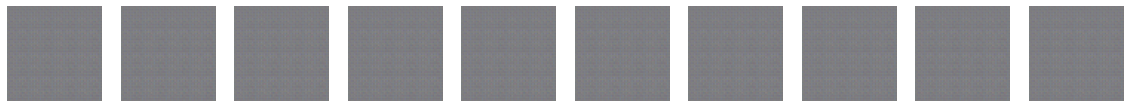

Epoch 100 	 g_loss: 336.9733, d_loss:66.3839, d_acc: 0.0000


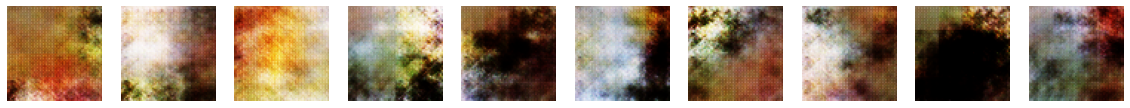

Epoch 200 	 g_loss: 311.6840, d_loss:77.5663, d_acc: 0.0000


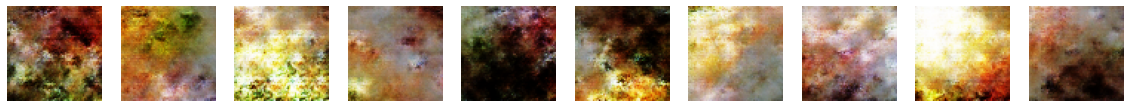

Epoch 300 	 g_loss: 326.7073, d_loss:77.9812, d_acc: 0.0000


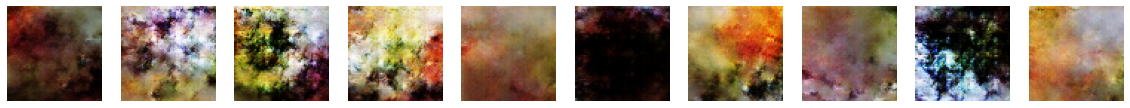

Epoch 400 	 g_loss: 272.5966, d_loss:71.4153, d_acc: 0.0000


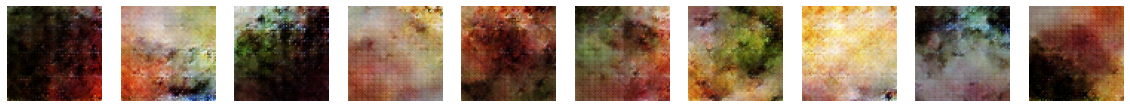

Epoch 500 	 g_loss: 229.3447, d_loss:70.1127, d_acc: 0.0000


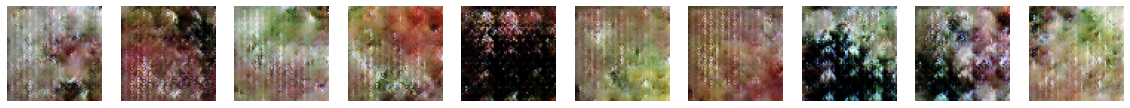

Epoch 600 	 g_loss: 311.4238, d_loss:78.9771, d_acc: 0.0000


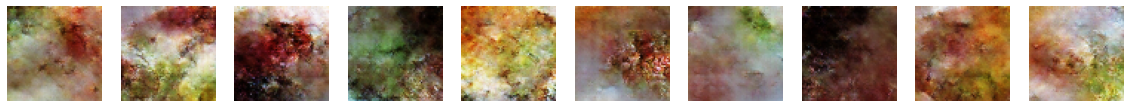

Epoch 700 	 g_loss: 316.8952, d_loss:84.6299, d_acc: 0.0000


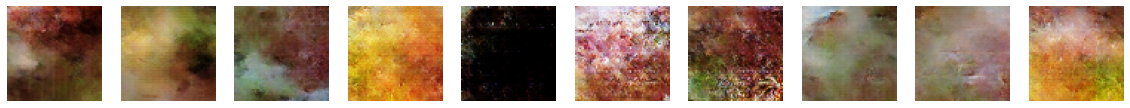

Epoch 800 	 g_loss: 316.8735, d_loss:79.1863, d_acc: 0.0000


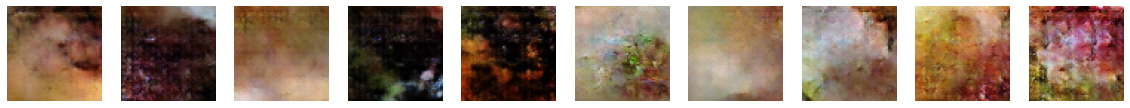

Epoch 900 	 g_loss: 318.2853, d_loss:74.6204, d_acc: 0.0000


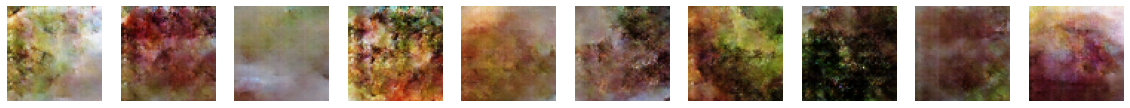

Epoch 1000 	 g_loss: 329.7924, d_loss:79.4825, d_acc: 0.0000


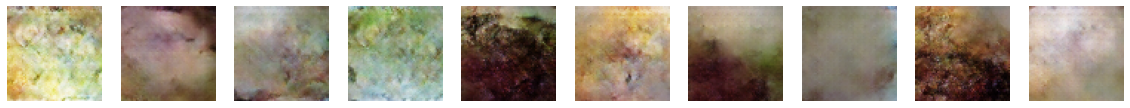

Epoch 1100 	 g_loss: 320.4618, d_loss:86.5673, d_acc: 0.0000


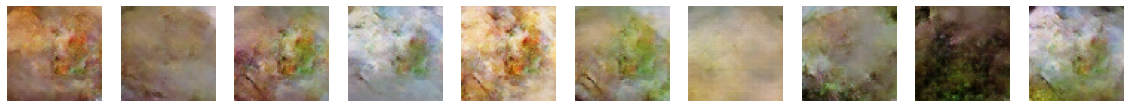

Epoch 1200 	 g_loss: 317.2340, d_loss:77.8378, d_acc: 0.0000


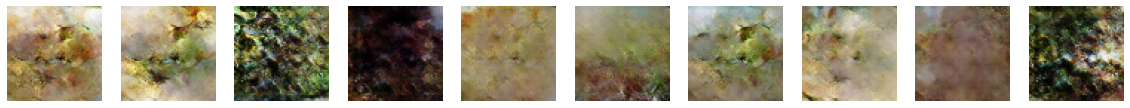

Epoch 1300 	 g_loss: 305.4813, d_loss:74.9407, d_acc: 0.0000


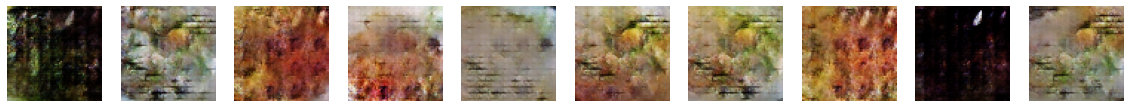

Epoch 1400 	 g_loss: 321.4344, d_loss:74.5269, d_acc: 0.0000


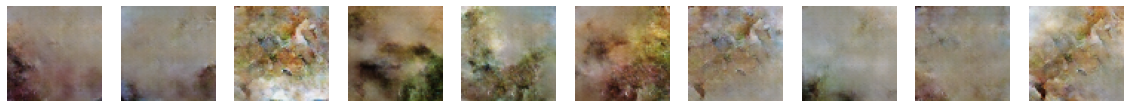

Epoch 1500 	 g_loss: 301.1410, d_loss:72.7754, d_acc: 0.0000


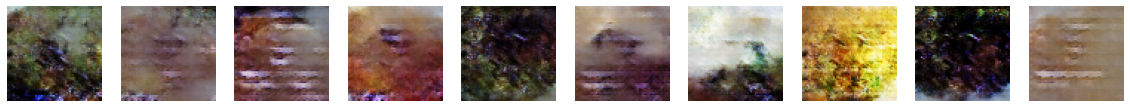

Epoch 1600 	 g_loss: 300.7325, d_loss:77.8303, d_acc: 0.0000


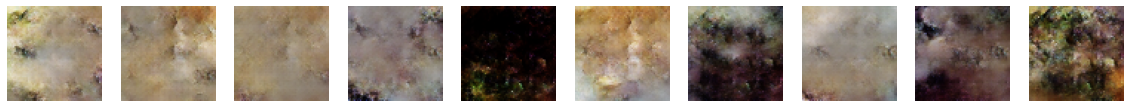

Epoch 1700 	 g_loss: 318.8464, d_loss:82.3751, d_acc: 0.0000


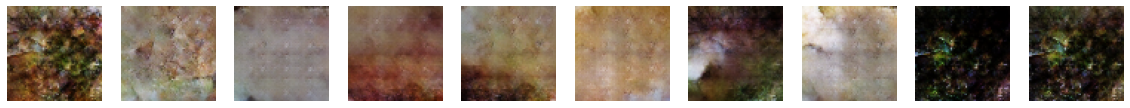

Epoch 1800 	 g_loss: 351.8525, d_loss:60.3778, d_acc: 0.0000


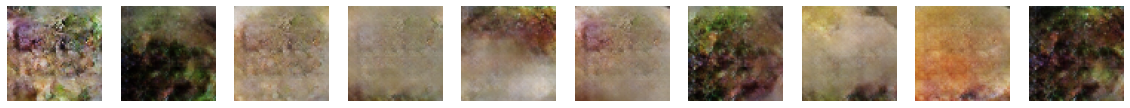

Epoch 1900 	 g_loss: 306.2277, d_loss:81.6395, d_acc: 0.0000


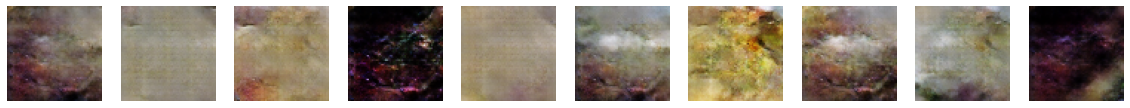

Epoch 2000 	 g_loss: 322.9128, d_loss:76.6035, d_acc: 0.0000


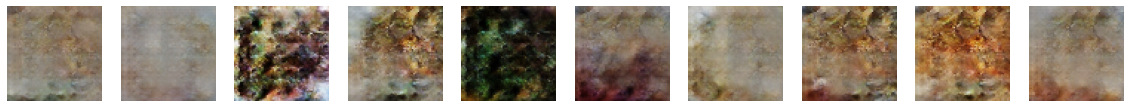

Epoch 2100 	 g_loss: 315.3565, d_loss:73.3660, d_acc: 0.0000


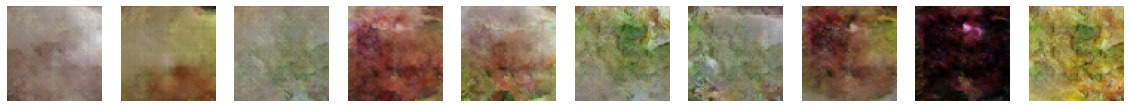

Epoch 2200 	 g_loss: 318.3154, d_loss:79.9071, d_acc: 0.0000


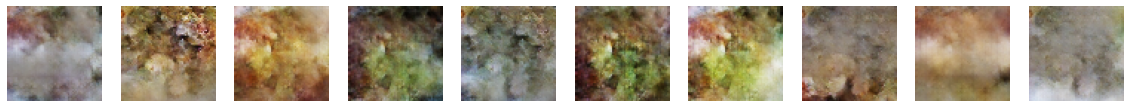

In [ ]:
## Hyperparameters
hidden_dim = 100
epochs = 5000
batch_size = 64
display_epochs = 100

## build the generator
generator = build_generator_DC(hidden_dim)
generator.summary()

## build the dicriminator and compile
discriminator = build_discriminator_DC()
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 2e-4, beta_1 = 0.5), metrics = ['accuracy'])
discriminator.summary()

## build the combine model
DCGAN = build_DCGAN(hidden_dim, generator, discriminator)
DCGAN.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-5, beta_1 = 0.5))
DCGAN.summary()

## batch info (m = 10099) 
n_batch = m // batch_size
n_remain = m % batch_size


def train_DCGAN(epochs, batch_size, display_epochs):
    
    # losses for each epochs
    d_loss_history = []
    g_loss_history = []


    for epoch in range(epochs+1):

        d_loss = 0
        g_loss = 0
        d_acc = 0


        for batch_i in range(n_batch + 1):

            # sample size
            if batch_i != n_batch:
                sample_size = batch_size
            else:
                sample_size = n_remain

            # take a batch of real images
            if batch_i != n_batch:
                real_images = data[batch_i*batch_size : (batch_i+1)*batch_size]
                assert real_images.shape[0] == batch_size
                real_labels = smoothing_true_labels(np.ones(batch_size))
                #real_labels = np.ones(batch_size)
            else: # last batch
                real_images = data[-n_remain:]
                assert real_images.shape[0] == n_remain
                real_labels = smoothing_true_labels(np.ones(n_remain))
                #real_labels = np.ones(n_remain)
            
            # create a batch of fake images
            #z = np.random.randn(sample_size, hidden_dim)
            z = np.random.uniform(low = 0.0, high=1.0, size = (sample_size, hidden_dim))
            fake_images = generator.predict(z)
            fake_labels = smoothing_fake_labels(np.zeros(sample_size))
            #fake_labels = np.zeros(sample_size)

            # train discriminator
            d_real_loss, d_real_acc = discriminator.train_on_batch(real_images, real_labels)
            d_fake_loss, d_fake_acc = discriminator.train_on_batch(fake_images, fake_labels)

            d_loss += (d_real_loss + d_fake_loss)
            d_acc += (d_real_acc + d_fake_acc)*sample_size

            # train generator
            z = np.random.uniform(low = 0.0, high=1.0, size = (sample_size, hidden_dim))
            g_loss += DCGAN.train_on_batch(z, np.ones(sample_size))
        
        
        d_acc /= (2*m)

        # log losses
        g_loss_history.append(g_loss)
        d_loss_history.append(d_loss)

        if epoch % display_epochs == 0:
            # print info
            print("Epoch {} \t g_loss: {:.4f}, d_loss:{:.4f}, d_acc: {:.4f}".format(
                    epoch, g_loss, d_loss, d_acc))
            
            # plot fake images
            plt.figure(figsize = (20, 4))
            for i in range(10):
                fake_img = fake_images.copy()[i].reshape(64, 64, 3)
                fake_img = (127.5*(fake_img + 1)).astype(int)
                plt.subplot(1, 10, i+1)
                plt.axis('off')
                plt.imshow(fake_img)
            plt.show()

            
    return (g_loss_history, d_loss_history)
    
## Train
g_loss_history, d_loss_history = train_DCGAN(epochs, batch_size, display_epochs)


## Plot loss during training
plt.figure()
plt.plot(g_loss_history, 'b')
plt.plot(d_loss_history, 'r')
plt.show()